In [2]:
import sys
# adding notebooks to the system path
sys.path.insert(0, '/home/southark/notebooks')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.4f}'.format
import matplotlib
from tqdm import tqdm
import scanpy as sc
import scipy

matplotlib.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2 
%matplotlib inline

from perturbseq import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from hits.visualize import interactive

Loading BokehJS ...

In [4]:
import bokeh
bokeh.io.output_notebook()

Loading BokehJS ...

In [5]:
k562_pop = CellPopulation.from_hdf('/data/norman/datasets/genomewide_perturbseq/K562_essential_pop_filtered_single_cells.hdf')

Loading matrix...
Available keys: ['/cell_list', '/gene_list', '/matrix']
Loading metadata...
Done in 99.74753546714783s.
Done.


In [6]:
rpe1_pop = CellPopulation.from_hdf('/data/norman/datasets/genomewide_perturbseq/rpe1_pop_01_filtered_single_cells.hdf')

Loading matrix...
Available keys: ['/cell_list', '/gene_list', '/matrix']
Loading metadata...
Done in 57.23943305015564s.
Done.


Mask the targets of guides in cells where they are perturbed with NaN so that they do not inflate CV estimates.

In [7]:
k562_target_genes = k562_pop.genes['gene_name']
k562_target_genes = k562_target_genes[~(k562_target_genes.str.contains('\.')|k562_target_genes.str.contains('-AS1'))]

k562_masked_coefs = k562_pop.matrix[k562_target_genes.index].copy()

k562_masked_coefs['target_gene_id'] = k562_pop.cells['gene_id']
k562_masked_coefs.set_index('target_gene_id', append=True, inplace=True)

# Iterate over the rows of the DataFrame
for row_index, row_data in tqdm(k562_masked_coefs.iterrows()):
    # Extracting the Ensembl ID from the second level of the multi-index
    target_gene_id = row_index[1]

    # Check if the Ensembl ID is not an empty string
    if target_gene_id != "":
        # Set the corresponding column's value to np.nan
        if target_gene_id in k562_masked_coefs.columns:
            k562_masked_coefs.at[row_index, target_gene_id] = np.nan
            
k562_masked_coefs = k562_masked_coefs.droplevel(1)

312024it [00:18, 16576.84it/s]


In [8]:
rpe1_target_genes = rpe1_pop.genes['gene_name']
rpe1_target_genes = rpe1_target_genes[~(rpe1_target_genes.str.contains('\.')|rpe1_target_genes.str.contains('-AS1'))]

rpe1_masked_coefs = rpe1_pop.matrix[rpe1_target_genes.index].copy()

rpe1_masked_coefs['target_gene_id'] = rpe1_pop.cells['gene_id']
rpe1_masked_coefs.set_index('target_gene_id', append=True, inplace=True)

# Iterate over the rows of the DataFrame
for row_index, row_data in tqdm(rpe1_masked_coefs.iterrows()):
    # Extracting the Ensembl ID from the second level of the multi-index
    target_gene_id = row_index[1]

    # Check if the Ensembl ID is not an empty string
    if target_gene_id != "":
        # Set the corresponding column's value to np.nan
        if target_gene_id in rpe1_masked_coefs.columns:
            rpe1_masked_coefs.at[row_index, target_gene_id] = np.nan
            
rpe1_masked_coefs = rpe1_masked_coefs.droplevel(1)

249569it [00:14, 16899.18it/s]


In final analysis, we restrict only to guides that have good representation in both K562 and RPE1 datasets so that we can compare effects of a common set of perturbations.

In [9]:
k562_guide_counts = k562_pop.cells.groupby('gene_transcript').size()
k562_well_represented = k562_guide_counts[k562_guide_counts>=10].index

In [10]:
rpe1_guide_counts = rpe1_pop.cells.groupby('gene_transcript').size()
rpe1_well_represented = rpe1_guide_counts[rpe1_guide_counts>=10].index

In [11]:
common_perturbations = np.intersect1d(k562_well_represented,
                                      rpe1_well_represented)

In [12]:
common_perturbations = [pert for pert in common_perturbations if 'non-targeting' not in pert]

In [13]:
len(common_perturbations)

2132

In [14]:
k562_control_std = k562_masked_coefs.loc[k562_pop.cells.query('clean_control').index].std()
k562_control_mean = k562_masked_coefs.loc[k562_pop.cells.query('clean_control').index].mean()
k562_control_cv = k562_control_std/k562_control_mean

active_common_idx = k562_pop.cells.query('gene_transcript in @common_perturbations').index
k562_active_std = k562_masked_coefs.loc[active_common_idx].std()
k562_active_mean = k562_masked_coefs.loc[active_common_idx].mean()
k562_active_cv = k562_active_std/k562_active_mean

In [15]:
rpe1_control_std = rpe1_masked_coefs.loc[rpe1_pop.cells.query('clean_control').index].std()
rpe1_control_mean = rpe1_masked_coefs.loc[rpe1_pop.cells.query('clean_control').index].mean()
rpe1_control_cv = rpe1_control_std/rpe1_control_mean

active_common_idx = rpe1_pop.cells.query('gene_transcript in @common_perturbations').index
rpe1_active_std = rpe1_masked_coefs.loc[active_common_idx].std()
rpe1_active_mean = rpe1_masked_coefs.loc[active_common_idx].mean()
rpe1_active_cv = rpe1_active_std/rpe1_active_mean

In [16]:
k562_df = pd.DataFrame([k562_control_cv, k562_active_cv,
                   np.log10(k562_control_mean), np.log10(k562_active_mean)], index=['control_cv', 'active_cv', 'control_mean', 'active_mean']).T

k562_df['gene_name'] = k562_pop.genes.loc[k562_df.index, 'gene_name']
k562_df = k562_df.set_index('gene_name')
k562_df = k562_df.dropna()
k562_df = k562_df[~k562_df.index.duplicated()]

In [17]:
rpe1_df = pd.DataFrame([rpe1_control_cv, rpe1_active_cv,
                   np.log10(rpe1_control_mean), np.log10(rpe1_active_mean)], index=['control_cv', 'active_cv', 'control_mean', 'active_mean']).T

rpe1_df['gene_name'] = rpe1_pop.genes.loc[rpe1_df.index, 'gene_name']
rpe1_df = rpe1_df.set_index('gene_name')
rpe1_df = rpe1_df.dropna()
rpe1_df = rpe1_df[~rpe1_df.index.duplicated()]

We do two corrections:

(1) There is a strong dependence of CV on mean. We compute "mean-corrected" CV estimates using a LOWESS filter. This provides an estimate of what the CV should be for a given mean expression level. To identify unexpectedly high variability, we then divide the observed value by this expected value. We call this "excess CV".

(2) Some genes are highly variable for reasons that have nothing to do with perturbations (e.g. cell cycle genes). To compensate for this, we estimate excess CV in control and perturbed cells and then compute the fold increase as an estimate of the effects of perturbations.

In [18]:
from scipy import stats
from statsmodels.nonparametric.smoothers_lowess import lowess

def compute_excess_cv(df, condition='control'):
    """
    Compute excess CV for a given condition using LOWESS regression on log-transformed data
    
    Parameters:
    -----------
    df : pandas DataFrame
        Contains mean and cv columns for the condition
    condition : str
        Either 'control' or 'active'
        
    Returns:
    --------
    excess_cv : pandas Series
        Excess CV values for each gene (ratio of observed to expected)
    expected_cv : pandas Series
        Expected CV values from LOWESS fit
    """
    mean_col = f'{condition}_mean'
    cv_col = f'{condition}_cv'
    
    # Log transform CV for fitting (mean is already in log10 space)
    log_cv = np.log10(df[cv_col])
    
    # Compute LOWESS fit in log space
    log_expected = lowess(
        log_cv,
        df[mean_col],
        frac=0.05,
        it=3,
        return_sorted=False
    )
    
    # Transform back to linear space
    expected_cv = 10**log_expected
    
    # Compute excess CV as ratio
    excess_cv = df[cv_col] / expected_cv
    
    return excess_cv, expected_cv

def analyze_differential_variability(df):
    """
    Analyze differential variability between conditions
    
    Parameters:
    -----------
    df : pandas DataFrame
        Contains mean and cv columns for both conditions
        
    Returns:
    --------
    results_df : pandas DataFrame
        Contains analysis results including excess CV and z-scores
    """
    # Compute excess CV for both conditions
    control_excess_cv, control_expected = compute_excess_cv(df, 'control')
    active_excess_cv, active_expected = compute_excess_cv(df, 'active')
    
    # Z-score the log of excess CV values
    control_z = stats.zscore(np.log10(control_excess_cv))
    active_z = stats.zscore(np.log10(active_excess_cv))
    
    # Compute differential variability score
    diff_var_score = active_z - control_z
    
    # Compile results
    results_df = pd.DataFrame({
        'control_excess_cv': control_excess_cv,
        'active_excess_cv': active_excess_cv,
        'control_z': control_z,
        'active_z': active_z,
        'diff_var_score': diff_var_score,
        'control_expected_cv': control_expected,
        'active_expected_cv': active_expected
    })
    
    return results_df

def plot_analysis_results(df, results_df):
    """
    Create diagnostic plots for the analysis
    """
    fig, axes = plt.subplots(2, 3, figsize=(20, 15))
    
    # Plot 1: Original CV ratio vs mean
    cv_ratio = df['active_cv'] / df['control_cv']
    axes[0,0].scatter(df['control_mean'], cv_ratio, alpha=0.5)
    axes[0,0].set_xlabel('Control Mean Expression (log10)')
    axes[0,0].set_ylabel('CV Ratio (Active/Control)')
    axes[0,0].set_title('Raw CV Ratio vs Expression Level')
    
    # Plot 2: LOWESS fits
    axes[0,1].scatter(df['control_mean'], np.log10(df['control_cv']), 
                     alpha=0.5, label='Control')
    axes[0,1].scatter(df['active_mean'], np.log10(df['active_cv']), 
                     alpha=0.5, label='Active')
    axes[0,1].scatter(df['control_mean'], np.log10(results_df['control_expected_cv']), label='Control Fit')
    axes[0,1].scatter(df['active_mean'], np.log10(results_df['active_expected_cv']), label='Active Fit')
    axes[0,1].set_xlabel('Mean Expression (log10)')
    axes[0,1].set_ylabel('CV (log10)')
    axes[0,1].legend()
    axes[0,1].set_title('LOWESS Fits of CV vs Expression')
    
    # Plot 3: Excess CV comparison (log scale)
    axes[1,0].scatter(np.log10(results_df['control_excess_cv']), 
                     np.log10(results_df['active_excess_cv']), 
                     alpha=0.5)
    axes[1,0].axline([0, 0], [1, 1], color='r', linestyle='--')
    axes[1,0].set_xlabel('Control log10(Excess CV)')
    axes[1,0].set_ylabel('Active log10(Excess CV)')
    axes[1,0].set_title('Excess CV Comparison')
    
    # Plot 4: Differential variability score distribution
    sns.histplot(results_df['diff_var_score'], kde=True, ax=axes[1,1])
    axes[1,1].set_xlabel('Differential Variability Score')
    axes[1,1].set_title('Distribution of Differential Variability Scores')
    
    # Plot 5: Z-score comparison
    axes[1,2].scatter(results_df['control_z'], results_df['active_z'], alpha=0.5)
    axes[1,2].axline([0, 0], [1, 1], color='r', linestyle='--')
    axes[1,2].set_xlabel('Control Z-score')
    axes[1,2].set_ylabel('Active Z-score')
    axes[1,2].set_title('Z-score Comparison')
    
    plt.tight_layout()
    return fig

def identify_variable_genes(results_df, quantile=0.99):
    """
    Identify genes with significantly increased variability
    
    Parameters:
    -----------
    results_df : pandas DataFrame
        Results from analyze_differential_variability
    quantile : float
        Quantile threshold for calling significant genes (e.g., 0.95 for top 5%)
        
    Returns:
    --------
    variable_genes : pandas DataFrame
        Genes with significantly increased variability in active condition
    threshold : float
        The differential variability score threshold used
    """
    threshold = np.quantile(results_df['diff_var_score'], quantile)
    variable_genes = results_df[results_df['diff_var_score'] > threshold].sort_values(
        'diff_var_score', ascending=False)
    return variable_genes


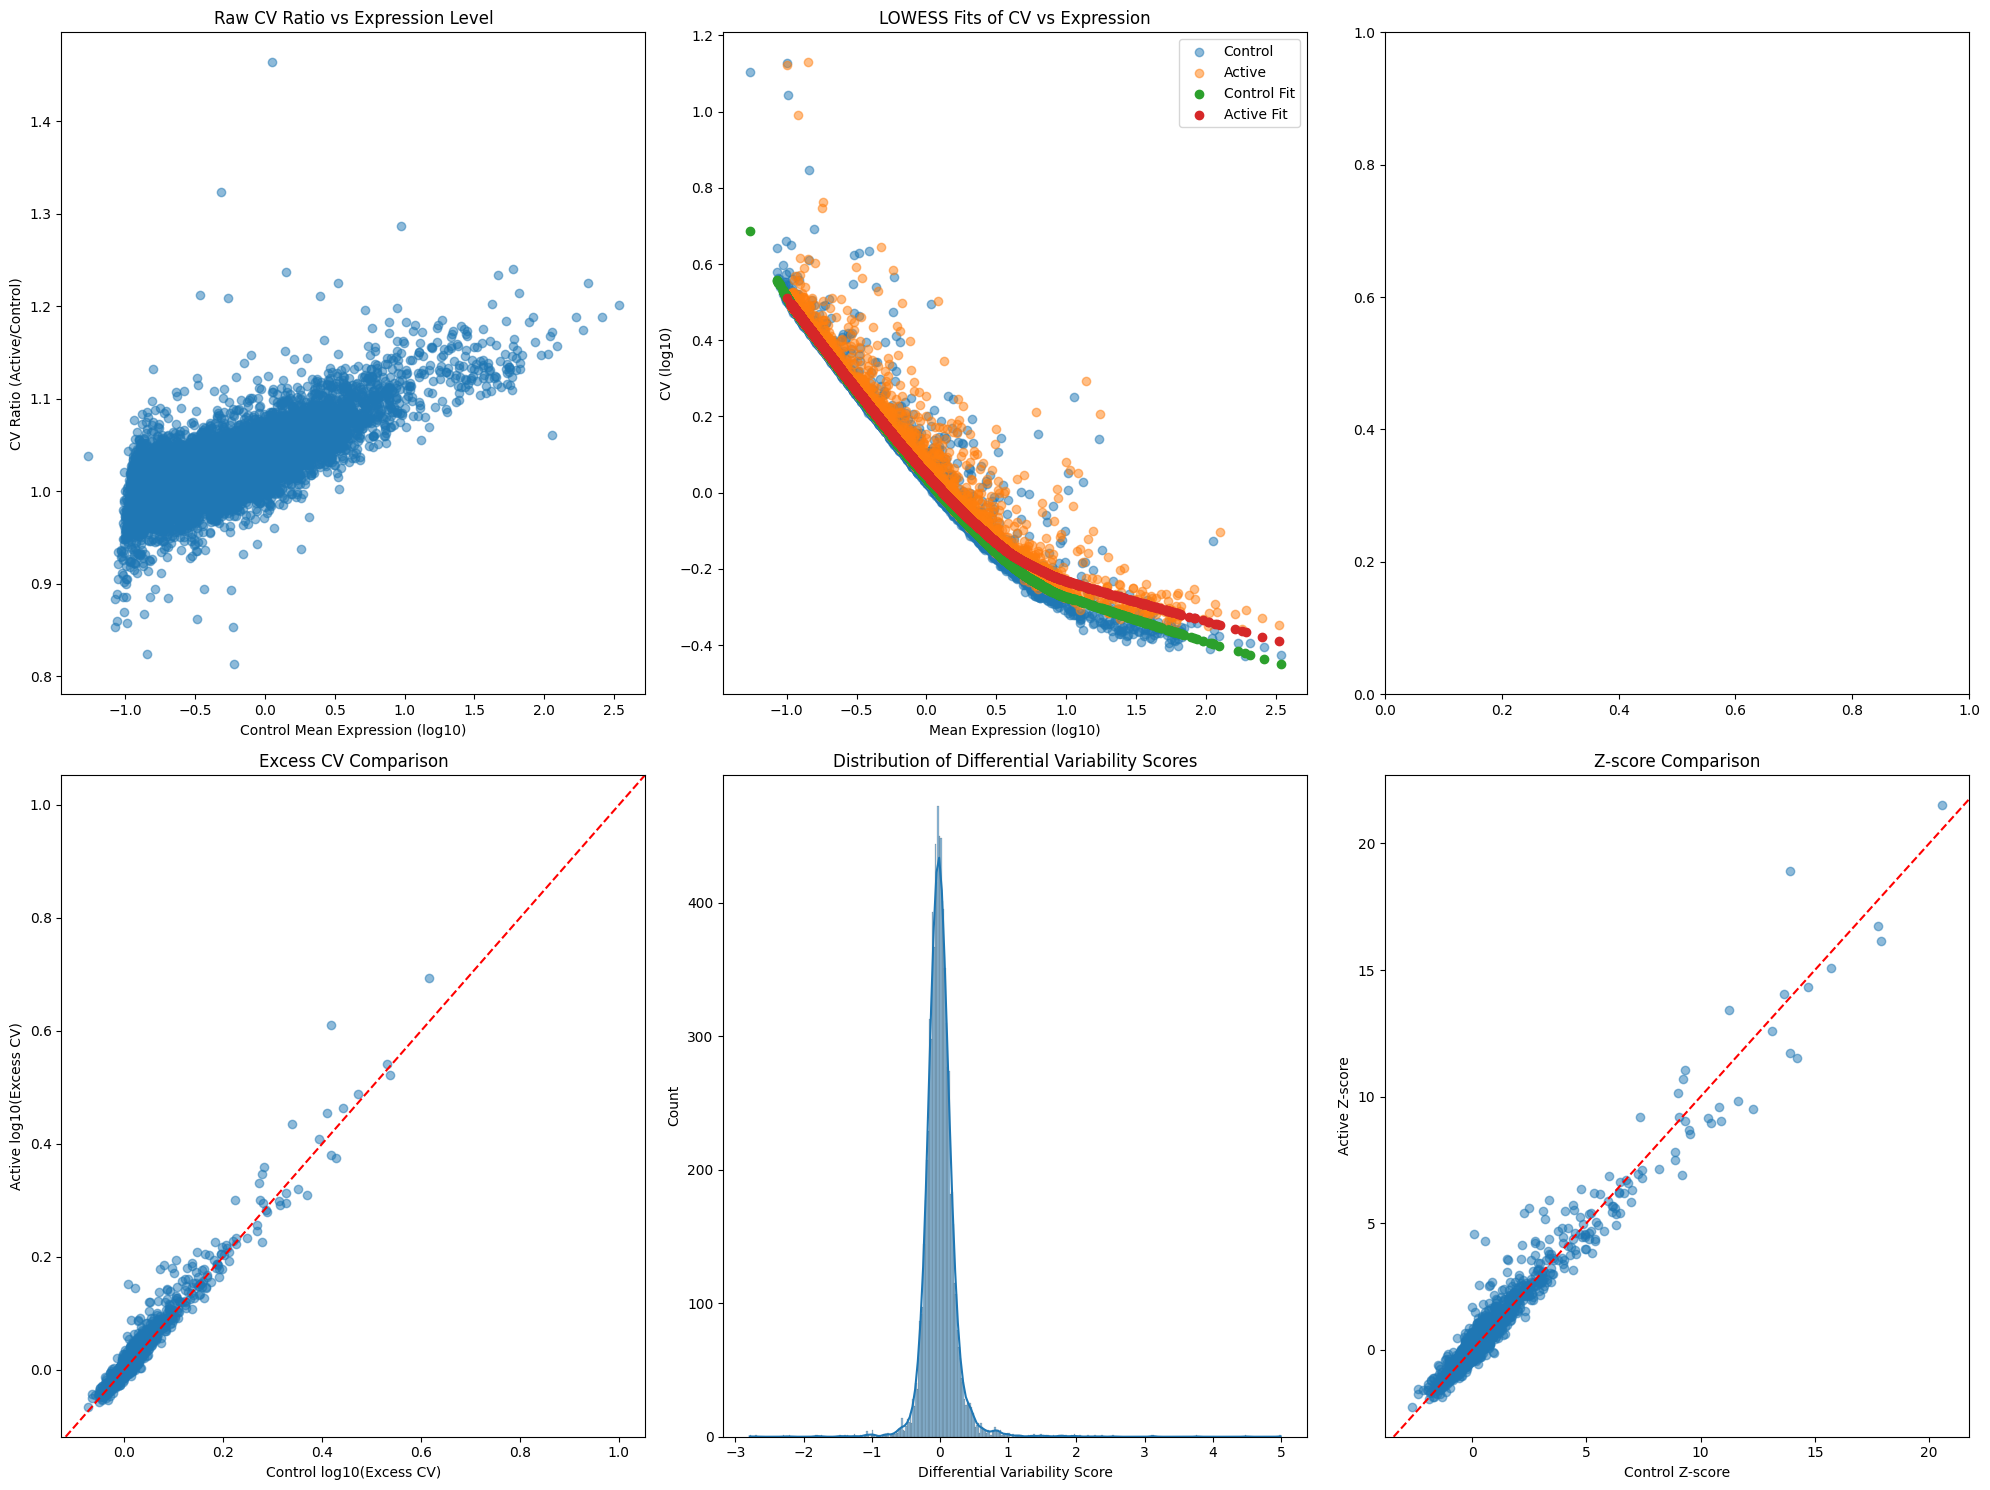

In [19]:
k562_results_df = analyze_differential_variability(k562_df)
fig = plot_analysis_results(k562_df, k562_results_df)
k562_variable_genes = identify_variable_genes(k562_results_df)
k562_results_df['fold_excess_cv'] = (k562_results_df['active_excess_cv']/k562_results_df['control_excess_cv']).sort_values()

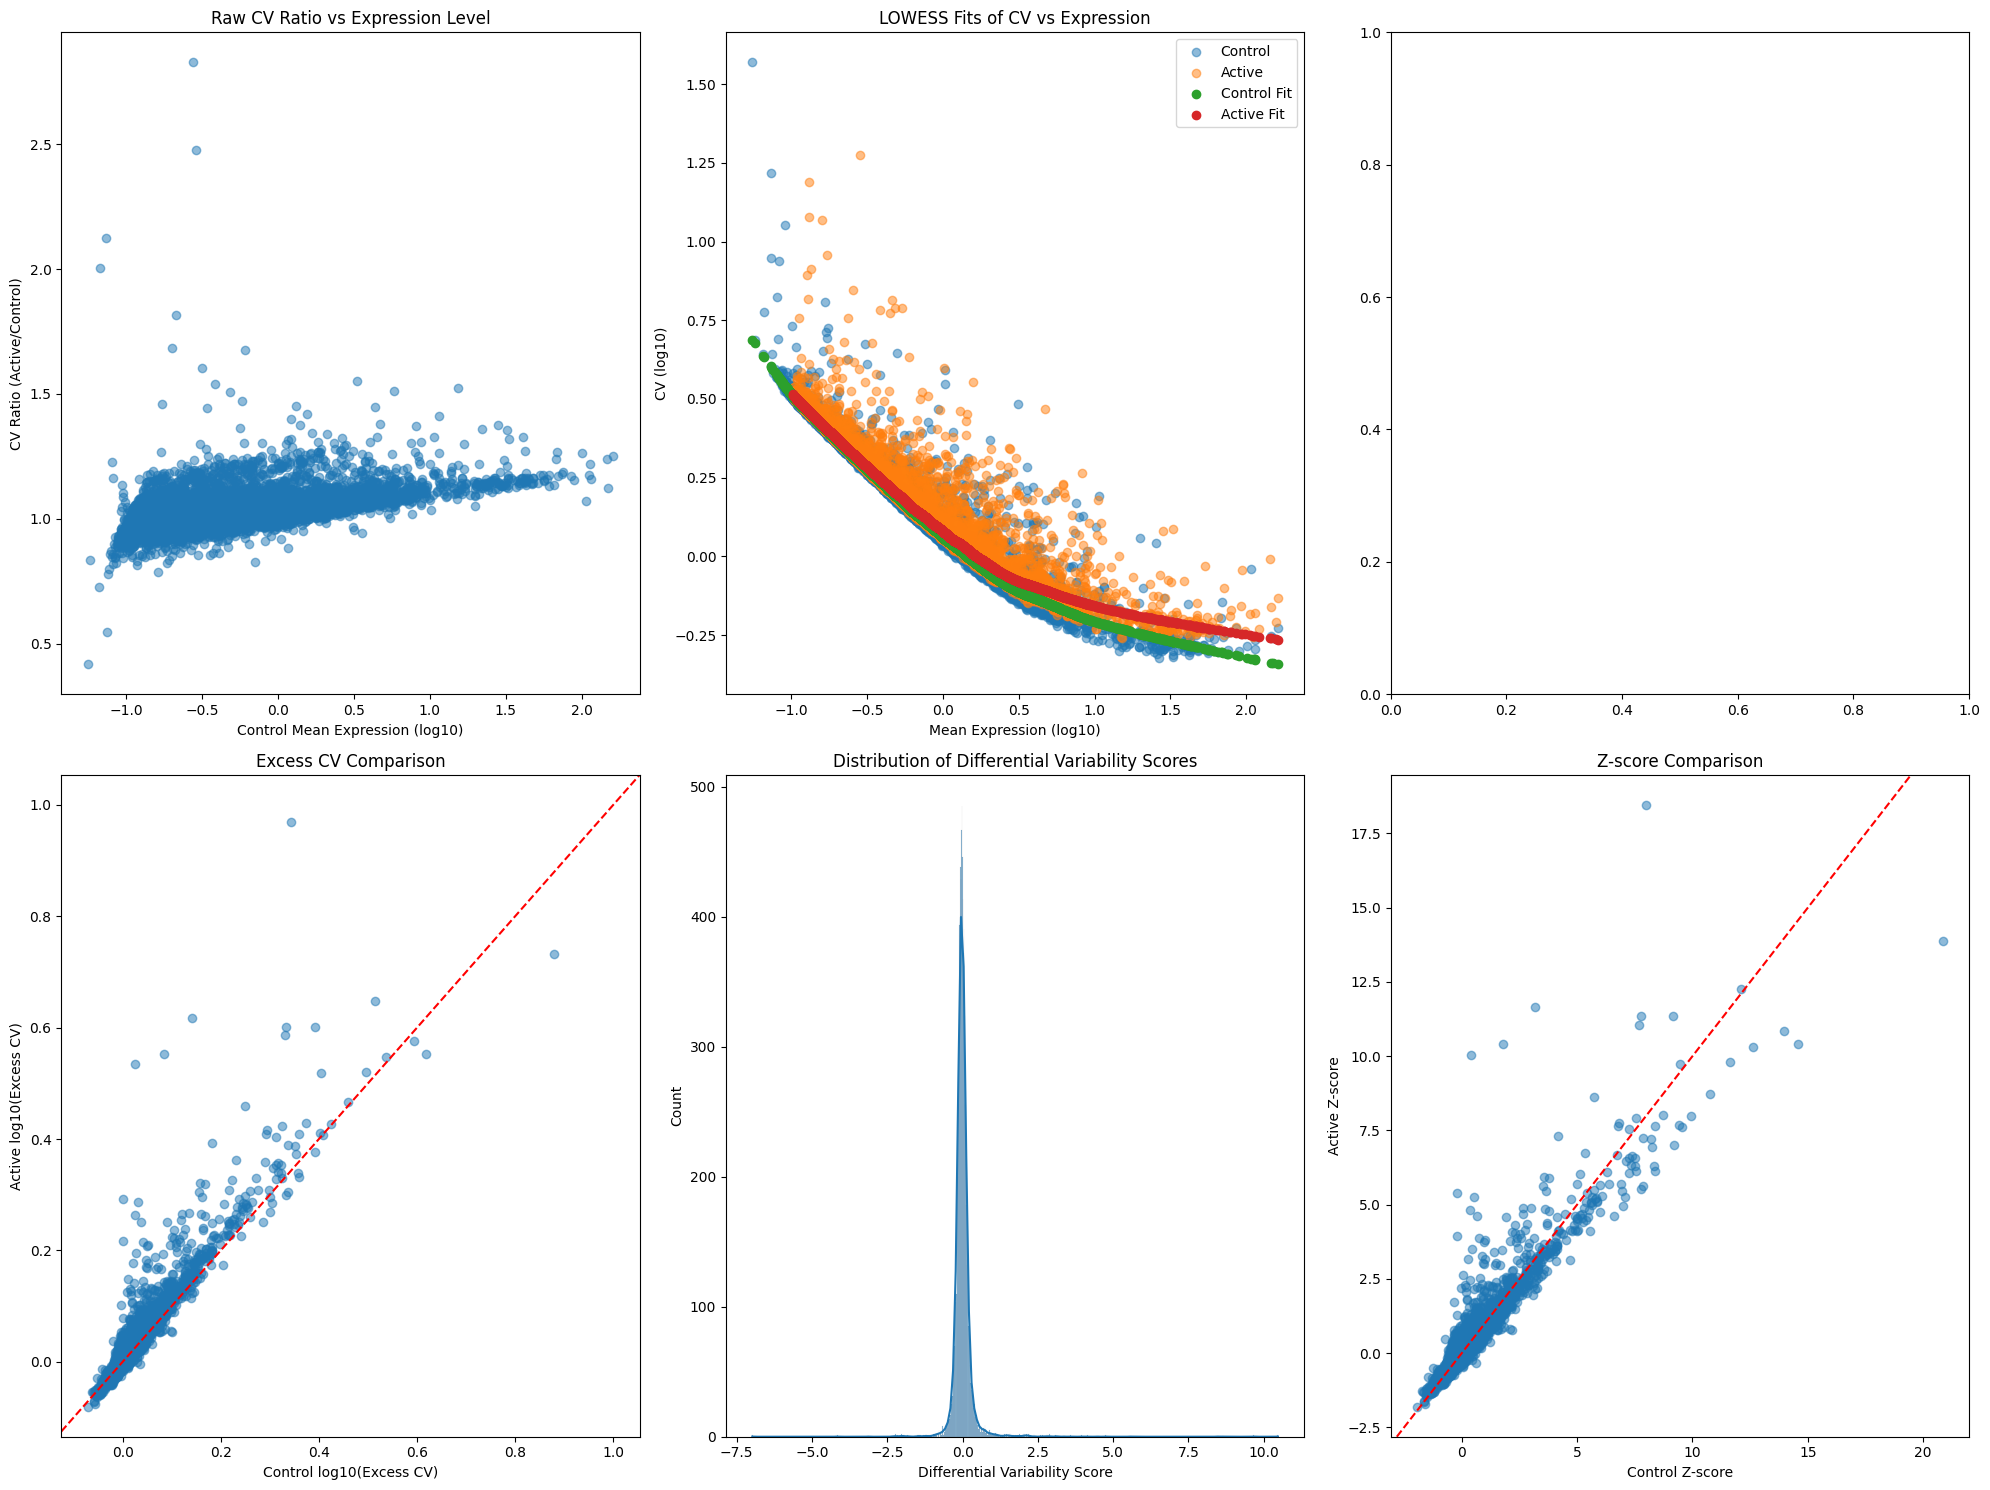

In [20]:
rpe1_results_df = analyze_differential_variability(rpe1_df)
fig = plot_analysis_results(rpe1_df, rpe1_results_df)
rpe1_variable_genes = identify_variable_genes(rpe1_results_df)
rpe1_results_df['fold_excess_cv'] = (rpe1_results_df['active_excess_cv']/rpe1_results_df['control_excess_cv']).sort_values()

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

def setup_publication_style():
    """Set up matplotlib style for publication-quality figures."""
    plt.style.use('seaborn-v0_8-whitegrid')
    
    colors = {
        'main_scatter': '#2c3e50',  # Dark blue-grey
        'k562_only': '#e74c3c',    # Dark red
        'rpe1_only': '#3498db',     # Bright blue
        'venn_colors': ['#e74c3c', '#3498db']  # Match the strip plots
    }
    
    FONT_SIZES = {
        'title': 12,
        'axis_label': 10,
        'tick_label': 9,
        'annotation': 8
    }
    
    return colors, FONT_SIZES

def get_axis_limits(df_both, df_fonly, df_ronly, xcol='plot_rpe1', ycol='plot_k562', padding=0.1):
    """Calculate consistent axis limits across all plots based on the specified columns."""
    all_x = pd.concat([
        df_both[xcol],
        df_ronly[xcol]
    ])
    all_y = pd.concat([
        df_both[ycol],
        df_fonly[ycol]
    ])
    
    x_min, x_max = all_x.min(), all_x.max()
    y_min, y_max = all_y.min(), all_y.max()
    
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    x_lim = (x_min - padding * x_range, x_max + padding * x_range)
    y_lim = (y_min - padding * y_range, y_max + padding * y_range)
    
    return x_lim, y_lim

def label_points_2d(ax, data, xcol, ycol, labelcol='gene_name'):
    """Label all points in a 2D scatter directly at their positions."""
    if data.empty:
        return
    
    for _, row in data.iterrows():
        ax.text(
            row[xcol],
            row[ycol],
            row[labelcol],
            fontsize=8,
            color='#2c3e50',
            ha='left', va='bottom'
        )

def label_points_1d(ax, data, col, labelcol='gene_name', orientation='vertical'):
    """Label all points in a strip plot directly at their scatter positions."""
    if data.empty:
        return

    # Get the plotted points
    points = ax.collections[0].get_offsets()
    
    # Get the values we're looking for
    target_values = data[col].values
    
    # For each target value, find the matching point
    for value in target_values:
        if orientation == 'vertical':
            # Find all points with matching y-coordinate (within small tolerance)
            matches = points[np.isclose(points[:, 1], value, rtol=1e-10)]
            if len(matches) > 0:
                label = data[data[col] == value].iloc[0][labelcol]
                ax.text(
                    matches[0, 0],  # x position from the point
                    matches[0, 1],  # y position from the point
                    label,
                    fontsize=8,
                    color='#2c3e50',
                    ha='left', va='center'
                )
        else:  # horizontal
            # Find all points with matching x-coordinate (within small tolerance)
            matches = points[np.isclose(points[:, 0], value, rtol=1e-10)]
            if len(matches) > 0:
                label = data[data[col] == value].iloc[0][labelcol]
                ax.text(
                    matches[0, 0],  # x position from the point
                    matches[0, 1],  # y position from the point
                    label,
                    fontsize=8,
                    color='#2c3e50',
                    ha='left', va='bottom'
                )

def create_publication_figure(df, quantile=0.95, log=True, vmin=None):
    """Create the complete publication-quality figure using quantile-based thresholds.

    Splits the DataFrame based on presence (non-NaN) of k562_excess_cv / rpe1_excess_cv:
      - df_both:    Genes measured in both k562 and RPE-1
      - df_fonly:   Genes measured only in k562
      - df_ronly:   Genes measured only in RPE-1

    Adds columns:
      - 'k562_cv_quantile' = rank of k562_excess_cv (fraction in [0,1])
      - 'rpe1_cv_quantile'  = rank of rpe1_excess_cv (fraction in [0,1])
      - 'plot_k562' and 'plot_rpe1' are created based on the `log` flag.

    Uses quantile-based thresholds T_k562, T_rpe1 to classify high-variance outliers.

    Args:
        df (DataFrame): Input data with columns 'k562_excess_cv' and 'rpe1_excess_cv'
        quantile (float): Quantile threshold for high variance genes.
        log (bool): If True, log-transform the values before plotting.
        vmin (float, optional): Minimum value for both x and y axes. If provided, the
            lower bound for both axes will be set to vmin.

    Returns:
        tuple: (figure, dict of hit gene lists)
            - figure: matplotlib figure object
            - hit_genes: dictionary containing lists of gene names for each category.
    """
    colors, FONT_SIZES = setup_publication_style()
    
    # ----- Add quantile columns -----
    df['k562_cv_quantile'] = df['k562_excess_cv'].rank(method='average', pct=True)
    df['rpe1_cv_quantile']  = df['rpe1_excess_cv'].rank(method='average', pct=True)
    
    # Calculate quantile-based thresholds using raw values
    T_k562 = df['k562_excess_cv'].quantile(quantile)
    T_rpe1  = df['rpe1_excess_cv'].quantile(quantile)
    
    # Create plotting columns based on the log flag
    if log:
        df['plot_k562'] = np.log10(df['k562_excess_cv'])
        df['plot_rpe1'] = np.log10(df['rpe1_excess_cv'])
        xlabel = 'log₁₀(RPE-1 Excess CV)'
        ylabel = 'log₁₀(k562 excess CV)'
    else:
        df['plot_k562'] = df['k562_excess_cv']
        df['plot_rpe1'] = df['rpe1_excess_cv']
        xlabel = 'RPE-1 Excess CV'
        ylabel = 'k562 excess CV'
    
    fig = plt.figure(figsize=(12, 12))
    gs = fig.add_gridspec(5, 5, hspace=0.3, wspace=0.3)
    
    # Identify high variance indices for each cell type using raw values
    k562_high_set = set(df.index[df['k562_excess_cv'] > T_k562])
    rpe1_high_set  = set(df.index[df['rpe1_excess_cv'] > T_rpe1])
    
    # Split data by whether each cell type is detected (non-NaN)
    df_both = df[(~df['k562_excess_cv'].isna()) & (~df['rpe1_excess_cv'].isna())].copy()
    df_fonly = df[(~df['k562_excess_cv'].isna()) & (df['rpe1_excess_cv'].isna())].copy()
    df_ronly = df[(df['k562_excess_cv'].isna()) & (~df['rpe1_excess_cv'].isna())].copy()
    
    # Filter high variance genes in each subset (using raw values for thresholds)
    df_both_hv = df_both[
        (df_both['k562_excess_cv'] > T_k562) | 
        (df_both['rpe1_excess_cv'] > T_rpe1)
    ].copy()
    df_fonly_hv = df_fonly[df_fonly['k562_excess_cv'] > T_k562].copy()
    df_ronly_hv = df_ronly[df_ronly['rpe1_excess_cv'] > T_rpe1].copy()
    
    # Get consistent axis limits based on the chosen plotting columns
    x_lim, y_lim = get_axis_limits(df_both, df_fonly, df_ronly, xcol='plot_rpe1', ycol='plot_k562')
    
    # Override lower limits with vmin if provided
    if vmin is not None:
        x_lim = (vmin, x_lim[1])
        y_lim = (vmin, y_lim[1])
    
    # Main scatter plot for genes detected in both cell types
    ax_main = fig.add_subplot(gs[1:4, 1:4])
    
    # Plot points that are not high variance in either cell type
    normal_points = df_both[
        (df_both['k562_excess_cv'] <= T_k562) & 
        (df_both['rpe1_excess_cv'] <= T_rpe1)
    ]
    ax_main.scatter(
        normal_points['plot_rpe1'],
        normal_points['plot_k562'],
        c=colors['main_scatter'],
        alpha=0.6,
        s=30,
        edgecolor='white',
        linewidth=0.5,
        label='Normal Variance'
    )
    
    # Plot points that are high variance in k562 only
    k562_hv = df_both[
        (df_both['k562_excess_cv'] > T_k562) & 
        (df_both['rpe1_excess_cv'] <= T_rpe1)
    ]
    ax_main.scatter(
        k562_hv['plot_rpe1'],
        k562_hv['plot_k562'],
        c=colors['k562_only'],
        alpha=0.6,
        s=30,
        edgecolor='white',
        linewidth=0.5,
        label='k562 High Variance'
    )
    
    # Plot points that are high variance in RPE1 only
    rpe1_hv = df_both[
        (df_both['rpe1_excess_cv'] > T_rpe1) & 
        (df_both['k562_excess_cv'] <= T_k562)
    ]
    ax_main.scatter(
        rpe1_hv['plot_rpe1'],
        rpe1_hv['plot_k562'],
        c=colors['rpe1_only'],
        alpha=0.6,
        s=30,
        edgecolor='white',
        linewidth=0.5,
        label='RPE1 High Variance'
    )
    
    # Plot points that are high variance in both
    both_hv = df_both[
        (df_both['k562_excess_cv'] > T_k562) & 
        (df_both['rpe1_excess_cv'] > T_rpe1)
    ]
    ax_main.scatter(
        both_hv['plot_rpe1'],
        both_hv['plot_k562'],
        c='#984EA3',  # Purple for overlap
        alpha=0.6,
        s=30,
        edgecolor='white',
        linewidth=0.5,
        label='Both High Variance'
    )
    
    ax_main.set_title('Co-detected genes', fontsize=FONT_SIZES['title'])
    ax_main.set_xlabel(xlabel, fontsize=FONT_SIZES['axis_label'])
    ax_main.set_ylabel(ylabel, fontsize=FONT_SIZES['axis_label'])
    ax_main.set_xlim(x_lim)
    ax_main.set_ylim(y_lim)
    
    # Label high variance genes in main scatter
    label_points_2d(ax_main, df_both_hv, 'plot_rpe1', 'plot_k562')
    
    # Venn diagram for high variance indices
    ax_venn = fig.add_subplot(gs[0, 0])
    venn2([k562_high_set, rpe1_high_set],
          set_labels=['K562', 'RPE-1'],
          set_colors=colors['venn_colors'],
          alpha=0.6,
          ax=ax_venn)
    ax_venn.set_title(f'Highly variable genes\n(Top {(1 - quantile)*100:.1f}%)', 
                      fontsize=FONT_SIZES['title'])
    
    # k562blast-only vertical strip plot
    ax_fonly = fig.add_subplot(gs[1:4, 0])
    sns.stripplot(
        y='plot_k562',
        data=df_fonly,
        color=colors['k562_only'],
        alpha=0.6,
        size=5,
        orient='v',
        jitter=0.4,
        ax=ax_fonly
    )
    ax_fonly.set_title('K562-only', fontsize=FONT_SIZES['title'])
    ax_fonly.set_ylabel(ylabel, fontsize=FONT_SIZES['axis_label'])
    ax_fonly.set_ylim(y_lim)
    
    # Label high variance genes in the k562blast-only strip
    label_points_1d(ax_fonly, df_fonly_hv, 'plot_k562', orientation='vertical')
    
    # RPE-1-only horizontal strip plot
    ax_ronly = fig.add_subplot(gs[0, 1:4])
    sns.stripplot(
        x='plot_rpe1',
        data=df_ronly,
        color=colors['rpe1_only'],
        alpha=0.6,
        size=5,
        orient='h',
        jitter=0.4,
        ax=ax_ronly
    )
    ax_ronly.set_title('RPE1-only', fontsize=FONT_SIZES['title'])
    ax_ronly.set_xlabel(None)
    #ax_ronly.set_xlabel(xlabel, fontsize=FONT_SIZES['axis_label'])
    ax_ronly.set_xlim(x_lim)
    
    # Label high variance genes in the RPE-1-only strip
    label_points_1d(ax_ronly, df_ronly_hv, 'plot_rpe1', orientation='horizontal')
    
    plt.tight_layout()
    
    # Compile lists of hit genes
    k562_only_hits = k562_hv['gene_name'].tolist()        # HV only in k562 (co-detected)
    rpe1_only_hits  = rpe1_hv['gene_name'].tolist()           # HV only in RPE1 (co-detected)
    shared_hits     = both_hv['gene_name'].tolist()           # HV in both (co-detected)
    k562_specific_hits = df_fonly_hv['gene_name'].tolist()     # HV, measured only in k562
    rpe1_specific_hits  = df_ronly_hv['gene_name'].tolist()     # HV, measured only in RPE1
    
    hit_genes = {
        'coexpressed_k562_only_hits': k562_only_hits,
        'coexpressed_rpe1_only_hits': rpe1_only_hits,
        'coexpressed_shared_hits': shared_hits,
        'k562_specific_hits': k562_specific_hits,
        'rpe1_specific_hits': rpe1_specific_hits
    }
    
    return fig, hit_genes

# Example usage:
# fig, hit_genes = create_publication_figure(df, quantile=0.95, log=True)
# plt.savefig('gene_expression_analysis.pdf', dpi=300, bbox_inches='tight')
# plt.show()


We restrict our attention to genes that show some signs of being expressed at rest in control cells in either cell type.

In [30]:
shared_genes = np.union1d(k562_df.query('control_mean > -3').index, rpe1_df.query('control_mean > -3').index)

First we just look at the excess CV estimates. These are corrected for the effect of mean expression level, but will include sources of variation other than perturbations like the cell cycle.

In [44]:
df = pd.DataFrame([k562_results_df.reindex(shared_genes)['active_excess_cv'], rpe1_results_df.reindex(shared_genes)['active_excess_cv']],
                 index=['k562_excess_cv', 'rpe1_excess_cv']).T
df['gene_name'] = df.index

/tmp/ipykernel_661678/2270614816.py:306: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_661678/1974760558.py:3: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  plt.savefig('k562_vs_rpe1_excess_cv_full.pdf', dpi=300, bbox_inches='tight')
/tmp/ipykernel_661678/1974760558.py:3: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Liberation Sans.
  plt.savefig('k562_vs_rpe1_excess_cv_full.pdf', dpi=300, bbox_inches='tight')
/data/norman/southark/software/conda/envs/scanpy_perturbseq/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/norman/southark/software/conda/envs/scanpy_perturbseq/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from 

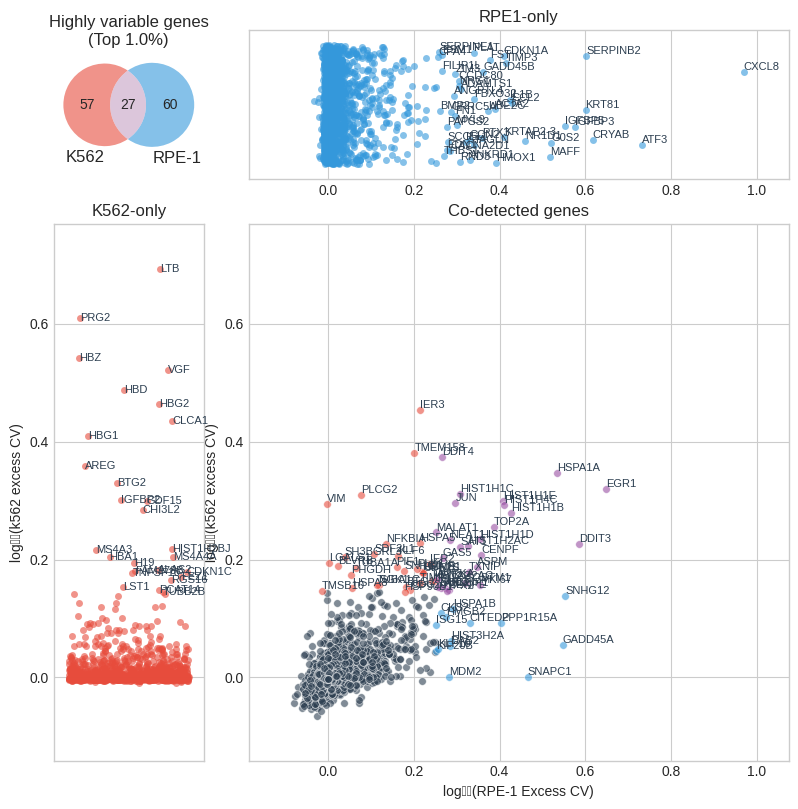

In [45]:
fig, gene_lists = create_publication_figure(df, quantile=0.99, log=True)

plt.savefig('k562_vs_rpe1_excess_cv_full.pdf', dpi=300, bbox_inches='tight')

To focus on perturbation-induced variability, we look at the increase in excess CV in perturbed cells vs. controls.

In [33]:
df = pd.DataFrame([k562_results_df.reindex(shared_genes)['fold_excess_cv'], rpe1_results_df.reindex(shared_genes)['fold_excess_cv']],
                 index=['k562_excess_cv', 'rpe1_excess_cv']).T
df['gene_name'] = df.index

Note that there are some genes that then show *less* variability than expected. We don't focus on those in the paper but these are likely things that become "more regulated" in perturbed cells than in controls.

/tmp/ipykernel_661678/2270614816.py:306: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_661678/608048912.py:3: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  plt.savefig('k562_vs_rpe1_excess_cv_all.pdf', dpi=300, bbox_inches='tight')
/tmp/ipykernel_661678/608048912.py:3: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Liberation Sans.
  plt.savefig('k562_vs_rpe1_excess_cv_all.pdf', dpi=300, bbox_inches='tight')
/data/norman/southark/software/conda/envs/scanpy_perturbseq/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/norman/southark/software/conda/envs/scanpy_perturbseq/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font

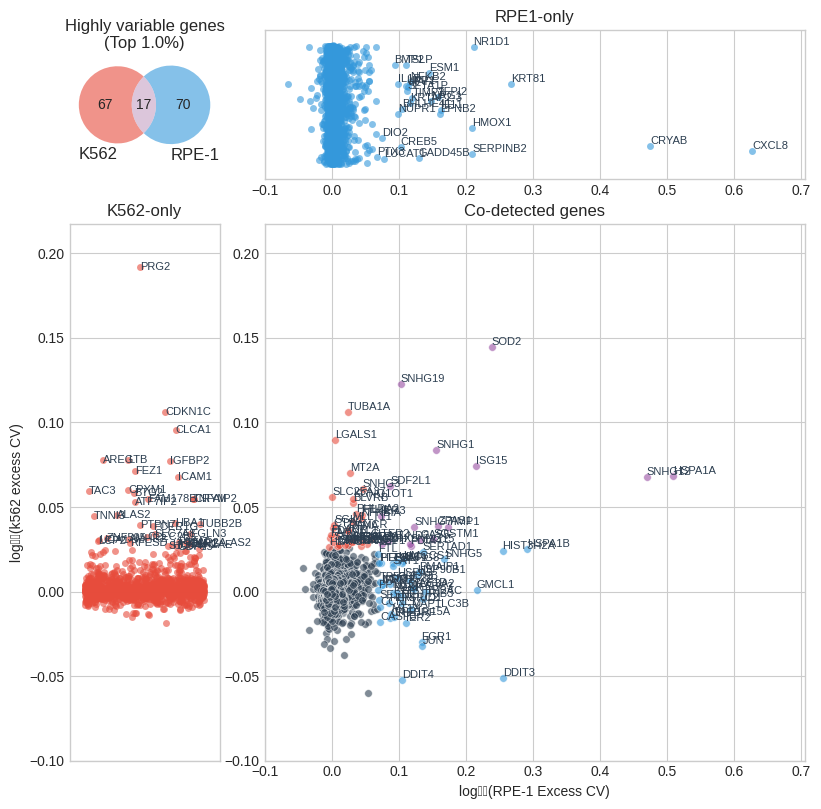

In [43]:
fig, gene_lists = create_publication_figure(df, quantile=0.99, log=True, vmin=-0.1)

plt.savefig('k562_vs_rpe1_excess_cv_all.pdf', dpi=300, bbox_inches='tight')

In [39]:
plt.savefig('k562_vs_rpe1_excess_cv_all.pdf', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [41]:
df.to_csv('pvg_k562_rpe1i.csv')

In [42]:
import csv

def export_as_key_value_pairs(dict_of_lists, filename):
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        # Write header
        writer.writerow(['List_Name', 'Values'])
        # Write each list on its own row
        for key, values in dict_of_lists.items():
            # Convert list to string, removing brackets
            values_str = ','.join(str(x) for x in values)
            writer.writerow([key, values_str])

# Example usage:
export_as_key_value_pairs(gene_lists, 'pvg_k562_rpe1i_top1.csv')

In [36]:
k562_results_df

,control_excess_cv,active_excess_cv,control_z,active_z,diff_var_score,control_expected_cv,active_expected_cv,fold_excess_cv
gene_name,,,,,,,,
LINC01409,1.0024,0.9991,-0.1359,-0.2096,-0.0736,2.8511,2.7626,0.9967
LINC01128,0.9928,0.9890,-0.2771,-0.3484,-0.0713,2.0107,2.0505,0.9961
NOC2L,1.0083,1.0028,-0.0498,-0.1595,-0.1097,0.8029,0.8640,0.9945
KLHL17,0.9940,0.9980,-0.2591,-0.2245,0.0346,2.8449,2.9667,1.0040
HES4,1.0439,1.0848,0.4575,0.9097,0.4522,2.0555,2.0781,1.0392
...,...,...,...,...,...,...,...,...
MT-ND4,1.0541,1.0982,0.5996,1.0769,0.4772,0.3835,0.4377,1.0419
MT-ND5,0.8618,0.9061,-2.3469,-1.5378,0.8091,0.4733,0.5291,1.0514
MT-ND6,1.2335,1.2847,2.8991,3.2098,0.3107,0.5328,0.5939,1.0415


In [37]:
plot_df = pd.DataFrame([np.log10(k562_results_df['control_excess_cv']), np.log10(k562_results_df['active_excess_cv'])],
                      index=['control_excess_cv', 'active_excess_cv']).T

In [38]:
interactive.scatter(plot_df)

AttributeError: unexpected attribute 'plot_width' to figure, similar attributes are outer_width, width or min_width

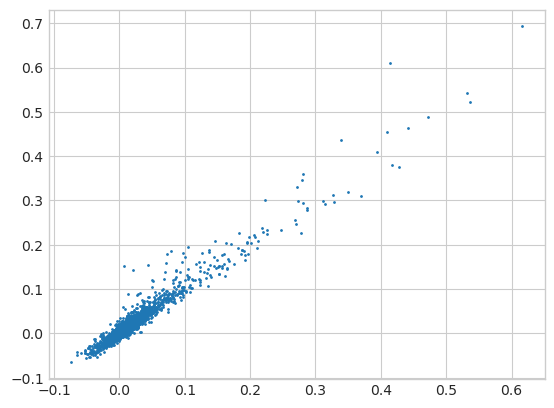

In [86]:
plt.scatter(np.log10(k562_results_df['control_excess_cv']), np.log10(k562_results_df['active_excess_cv']), s=1)

In [77]:
k562_results_df.loc['HBZ']

control_excess_cv      3.4011
active_excess_cv       3.4792
control_z             17.8344
active_z              16.7730
diff_var_score        -1.0613
control_expected_cv    0.5251
active_expected_cv     0.5658
fold_excess_cv         1.0230
Name: HBZ, dtype: float64

In [72]:
gene_lists

{'coexpressed_k562_only_hits': ['AL627171.2',
  'BLVRB',
  'CITED2',
  'CTSL',
  'DANCR',
  'DYNLL1',
  'FADS1',
  'FTH1',
  'GABPB1-AS1',
  'KCNQ1OT1',
  'LGALS1',
  'MARCKSL1',
  'MLLT11',
  'MT-ATP6',
  'MT2A',
  'NFKBIA',
  'NINJ1',
  'PHGDH',
  'PHLDA2',
  'PLAUR',
  'PTMA',
  'RANBP1',
  'RHOB',
  'S100A13',
  'SGK1',
  'SLC25A37',
  'SNHG10',
  'SNHG3',
  'SOX4',
  'TMEM99',
  'TUBA1A'],
 'coexpressed_rpe1_only_hits': ['AEN',
  'BBC3',
  'CASP3',
  'CCNL1',
  'CREBRF',
  'DDIT3',
  'DDIT4',
  'EGR1',
  'EPB41L4A-AS1',
  'FDXR',
  'GMCL1',
  'HERPUD1',
  'HES4',
  'HIST1H2AC',
  'HIST3H2A',
  'HMGCS1',
  'HSP90B1',
  'HSPA1B',
  'HSPA5',
  'IER2',
  'IFRD1',
  'JUN',
  'JUNB',
  'MAP1LC3B',
  'MDM2',
  'MT1X',
  'PMAIP1',
  'PPP1R15A',
  'PSAT1',
  'PTTG1',
  'RSRC2',
  'SAT1',
  'SERTAD1',
  'SESN2',
  'SLC3A2',
  'SNHG32',
  'SNHG5',
  'SNHG8',
  'TAF1D',
  'TP53I3',
  'TRIB3',
  'UBC'],
 'coexpressed_shared_hits': ['GAS5',
  'GLRX',
  'HSPA1A',
  'IER3',
  'ISG15',
  'MT-ND2',